In [14]:
import numpyro
import numpyro.distributions as dist
from numpyro.handlers import seed, trace
import jax
import jax.numpy as jnp
from jax import random
from jax.scipy.integrate import trapezoid

from sim_utils import *
from clip import *
import matplotlib.pylab as plt

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
dist.Normal(0, 1).sample(key, (nworms, 2))

Array([[ 0.08086783, -0.38624713],
       [-0.37565565,  1.6689739 ],
       [-1.2758198 ,  2.1192005 ],
       [-0.85821223,  1.1305932 ]], dtype=float32)

In [4]:
@partial(jax.jit, static_argnums=(1, 2))
def normal(key, loc=0.0, scale=1.0):
    key, sample_key = jax.random.split(key)
    samples = loc + jax.random.normal(sample_key, shape=(nworms,)) * scale
    return key, samples

@partial(jax.jit, static_argnums=(1, 2))
def uniform(key, low=0.0, high=1.0):
    key, sample_key = jax.random.split(key)
    samples = jax.random.uniform(sample_key, shape=(nworms,), minval=low, maxval=high)
    return key, samples

In [21]:

def sample(nworms):
    with numpyro.plate('nworms', nworms):
        # L = numpyro.sample('L', dist.Uniform(30, 45))
        L = numpyro.sample('L', dist.Uniform(10, 15))
        A = numpyro.sample('A', dist.Normal(1, 0.1))
        T = numpyro.sample('T', dist.Normal(0.8, 0.1))
        kw = numpyro.sample('kw', dist.Uniform(0, 2 * jnp.pi))
        ku = numpyro.sample('ku', dist.Normal(jnp.pi, 1))
        
        inc = numpyro.sample('inc', dist.Uniform(0, 2 * jnp.pi))
        dr = numpyro.sample('dr', dist.Uniform(0.2, 0.8))
        phase_1 = numpyro.sample('phase_1', dist.Uniform(0, 2 * jnp.pi))
        phase_2 = numpyro.sample('phase_2', dist.Uniform(0, 2 * jnp.pi))
        phase_3 = numpyro.sample('phase_3', dist.Normal(0, 0.1))
        alpha = numpyro.sample('alpha', dist.Normal(4, 4))

        alpha = jnp.abs(alpha + 1.0)
        half_box = box_size // 2
        x0 = numpyro.sample('x0', dist.Uniform(-half_box, half_box))
        y0 = numpyro.sample('y0', dist.Uniform(-half_box, half_box))

        params = {'L': L, 'A': A, 'T': T, 'kw': kw, 'ku': ku, 'inc': inc, 'dr': dr, 'phase_1': phase_1, 'phase_2': phase_2, 'phase_3': phase_3, 'alpha': alpha, 'x0': x0, 'y0': y0}
        duration = 0.55
        snapshots = 10
        kpoints = 6

        sim_fn = partial(
            worm_simulation,
            duration=duration,
            snapshots=snapshots,
            kpoints=kpoints,
        )
        worm = jax.vmap(sim_fn, out_axes=1)(params)
        worm = worm + box_size // 2
        numpyro.deterministic('worm', worm)


In [22]:
# seed and trace
key, nworms, box_size = random.PRNGKey(0), 2, 64

seeded_model = seed(sample, key)
tr = trace(seeded_model).get_trace(nworms)

In [23]:
tr['worm']['value']

Array([[[[ 4.65833893e+01,  7.31415749e+00],
         [ 4.78667145e+01,  9.33474541e+00],
         [ 4.97570190e+01,  1.08032265e+01],
         [ 5.19356003e+01,  1.17949409e+01],
         [ 5.40582390e+01,  1.29013290e+01],
         [ 5.56990662e+01,  1.46441383e+01]],

        [[ 5.97009354e+01,  5.65256348e+01],
         [ 5.77972374e+01,  5.72471771e+01],
         [ 5.71900253e+01,  5.91903687e+01],
         [ 5.86354599e+01,  6.06240349e+01],
         [ 6.06140480e+01,  6.11034927e+01],
         [ 6.24898834e+01,  6.18946495e+01]],

        [[ 8.95297050e+00,  5.32150269e-04],
         [ 7.45756721e+00,  1.16866302e+00],
         [ 7.98450279e+00,  2.99160004e+00],
         [ 9.87106705e+00,  3.19564629e+00],
         [ 1.17419968e+01,  2.87880898e+00],
         [ 1.32948952e+01,  3.96934509e+00]],

        [[ 1.53422699e+01,  6.14847031e+01],
         [ 1.44152737e+01,  5.93555908e+01],
         [ 1.44722614e+01,  5.70341301e+01],
         [ 1.51788998e+01,  5.48220940e+01],
    

In [24]:
clip = convert_to_clip(tr['worm']['value'], box_size)

In [27]:
tr['worm']['value'].shape

(10, 4, 6, 2)

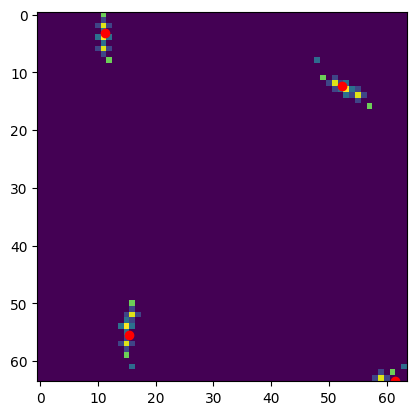

In [40]:
i = 9
plt.imshow(clip[i])
# plot points at means
# plt.scatter(tr['x0']['value'], tr['y0']['value'])
plt.scatter(tr['worm']['value'].mean(axis=-2)[i, ..., 0], tr['worm']['value'].mean(axis=-2)[i, ..., 1], c='r')
# plt.scatter(tr['worm']['value'].mean(axis=-2)[0, ..., 0], tr['worm']['value'].mean(axis=-2)[0, ..., 1], c='r')